In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Step_1_Climate_Analysis_And_Exploration/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
from sqlalchemy import inspect
inspector = inspect(engine)
for table in inspector.get_table_names():
    vars()[table.title()] = Base.classes[table] # Use [table] instead of Base.classes.table, which would not work.
    print("Table Name: " + table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
    print("----------------")
# This is a cleaner method and avoids using "exec()" which is vulnerable/not production quality.

Table Name: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
Table Name: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
----------------


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
calc_temps('2010-01-01', '2010-12-31')

[(56.0, 72.49568965517241, 87.0)]

Text(0, 0.5, 'Temperature')

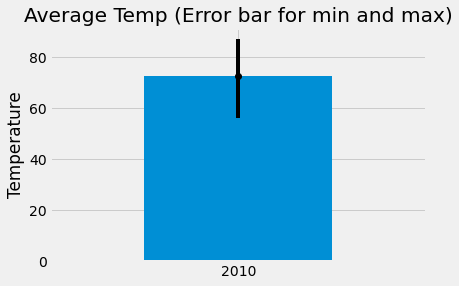

In [108]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps_2010 = calc_temps('2010-01-01', '2010-12-31')
temp_2010_avg = temps_2010[0][1]
err = [temp_2010_avg-temps_2010[0][0],temps_2010[0][2]-temp_2010_avg]
labels = ["2010"]
x = np.arange(len(labels))
fig, ax = plt.subplots()
ax.bar(x=x,height = temp_2010_avg,width=0.2)
ax.errorbar(x, temp_2010_avg, yerr=np.array([[err[0] ,err[1]]]).T, 
         fmt='ko')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlim(x-0.2,x+0.2)
ax.set_title("Average Temp (Error bar for min and max)")
ax.set_ylabel("Temperature")

### Daily Rainfall Average

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
# Close Session
session.close()